# Implementing a Mixed Naive Bayes Classifier
In this notebook, we implement and evaluate a mixed naive Bayes classification algorithm. Unlike the Bernoulli naive Bayes classifier which models each feature's class conditional probability with a Bernoulli distribution, a mixed naive Bayes classifier is a more generalized model that models different features with different families of class conditional distributions.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from matplotlib import rcParams
from sklearn.metrics import accuracy_score, confusion_matrix

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Spam vs. Non-spam
The data consists of examples of spam and non-spam emails, of which there are 4508 training examples and 93 testing examples. The feature vector $x$ is a 57-dimensional vector extracted from the email and $y = 1$ indicates a spam email. The data has been preprocessed such that the first 54 dimensions of each observation is binary and the last three dimensions are positive numbers.

For the naive Bayes classifier, we use 54 Bernoulli distributions for the 54 binary dimensions and 3 Pareto distributions for the last 3 positive dimensions. We choose the Pareto distribution because it is able to model outliers more easily, which the data seems to have many of.

In [12]:
data_path = os.path.join('data', 'spam')

X_train = pd.read_csv(os.path.join(data_path, 'X_train.csv'), header = None)
X_test = pd.read_csv(os.path.join(data_path, 'X_test.csv'), header = None)
y_train = pd.read_csv(os.path.join(data_path, 'y_train.csv'), header = None)
y_test = pd.read_csv(os.path.join(data_path, 'y_test.csv'), header = None)

print(X_train.shape)
print(X_test.shape)

(4508, 57)
(93, 57)


# Mixed Naive Bayes Classifier

For a labeled set of data $(y_1, x_1), ..., (y_n, x_n)$, where for this problem $y \in \{0,1\}$ and $x$ is a $D$-dimensional vector. The Bayes classifier observes a new $x_0$ and predicts $y_0$ as $$y_0 = \arg\max_y p(y_0 = y|\pi)\prod_{d=1}^{D}p_d(x_{0,d}|\theta_y^{(d)})$$ The distribution $p(y_0 = y|\pi)$ = Bernoulli($y|\pi$). What is "naive" about this classifier is the assumption that all $D$ dimensions of $x$ are independent. We can pick any distribution $p_d$ we think appropriate for the $d$th dimension. In this problem, $D = 57$ and $p_j$ are Bernoulli distributions for $j = 1, 2, ..., 54$ and Pareto distributions for $j = 55, 56, 57$.

That is, for Bernoulli distributions, $$p_j(x_{0,j}|\theta_y^{(j)}) = (\theta_y^{(j)})^{x_{0,j}}(1 - \theta_y^{(j)})^{1-x_{0,j}}$$

and for Pareto distributions, $$p_j(x_{0,j}|\theta_y^{(j)}) = \theta_y^{(j)}(x_{0,j})^{-(\theta_y^{(j)}+1)}$$.

The parameter $\theta_y^{(j)} \in [0,1]$ for Bernoulli distributions and $\theta_y^{(j)} > 0$ for Pareto distributions. For the class prior Bernoulli distribution, $\pi \in [0, 1]$. Given some data $(y_1, x_1), ..., (y_n, x_n)$, the maximum likelihood solution for $\pi$, $\theta_y^{(1)}, ..., \theta_y^{(D)}$, i.e., $$\hat{\pi}, \hat{\theta}_y^{(1)}, ..., \hat{\theta}_y^{(D)} = \arg\max_{\hat{\pi}, \hat{\theta}_y^{(1)}, ..., \hat{\theta}_y^{(D)}} \sum^{n}_{i=1} \ln p(y_i|\pi) +\sum_{j=1}^{D}\sum_{i=1}^{n}\ln p_j(x_{ij}|\theta_{y_i}^{(j)})$$.

Solving the above yields:

$$\hat{\pi} = \frac{\sum^{n}_{i=1} y_i}{n}$$

for $j = 1, 2, ..., 54$:

$$\hat{\theta}_{y}^{(j)}  = \frac{\sum_{i=1}^{n} x_{ij}\mathbb{1}(y_i = y)}{\sum_{i=1}^{n}\mathbb{1}(y_i = y)}$$ 

for $j = 55, 56, 57$:

$$\hat{\theta}_{y}^{(j)} =\frac{\sum_{i=1}^{n} \mathbb{1}(y_i = y)}{\sum_{i=1}^{n} \ln (x_{ij}) \mathbb{1}(y_i = y)}$$

In [7]:
class MixedNaiveBayes:
    
    def __init__(self, alpha = 0):
        self.alpha = alpha
        return
    
    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.pareto_indices = np.where(np.any(X > 1, axis = 0))[0].tolist()
        self.bernoulli_indices = np.where(np.all(X < 2, axis = 0))[0].tolist()
        
        X_bernoulli = X.iloc[:, self.bernoulli_indices]
        X_pareto = X.iloc[:, self.pareto_indices]
        
        self.log_class_prior = np.log(y[0].value_counts() / len(y_train)).values
        
        # learn class conditional probabilities for Bernoulli features
        class_conditional_bernoulli = \
            X_bernoulli.T.dot(np.column_stack([~y.astype(bool), y])) / \
            y[0].value_counts().values
            
        self.log_class_conditional_bernoulli = \
            np.log(class_conditional_bernoulli)
            
        self.log_class_conditional_bernoulli_neg = \
            np.log(1 - class_conditional_bernoulli)
            
        # learn class conditional probabilities for Pareto features
        denom = np.log(X_pareto).T.dot(np.column_stack([~y.astype(bool), y]))
        self.pareto_params = y[0].value_counts().values / denom
            
    def predict(self, X):
        X_bernoulli = X.iloc[:, self.bernoulli_indices]
        X_pareto = X.iloc[:, self.pareto_indices]
        
        # accumulate log class conditional bernoulli probabilities
        log_posterior = X_bernoulli.dot(self.log_class_conditional_bernoulli)
        log_posterior += np.logical_not(X_bernoulli) \
            .dot(self.log_class_conditional_bernoulli_neg)
        
        # accumulate log class conditional pareto probabilities
        log_posterior += -np.log(X_pareto).dot(self.pareto_params + 1)
        log_posterior += np.log(self.pareto_params).sum(axis = 0)
                
        # add log class prior
        log_posterior += self.log_class_prior
        
        return np.argmax(log_posterior.values, axis = 1)

Fitting the mixed naive Bayes classifier on training data and evaluate its performance on test data shows that it can classify spam from non-spam with 92.5% accuracy.

In [ ]:
mnb = MixedNaiveBayes()
mnb.fit(X_train, y_train)

print('confusion_matrix:\n', confusion_matrix(y_test, mnb.predict(X_test)))
print()
print('test accuracy:\n', accuracy_score(y_test, mnb.predict(X_test)))

Plotting the parameters of the Bernoulli features shows that the tokens **free**, **!**, and **$** are among those much more likely to appear in spam than non-spam emails.

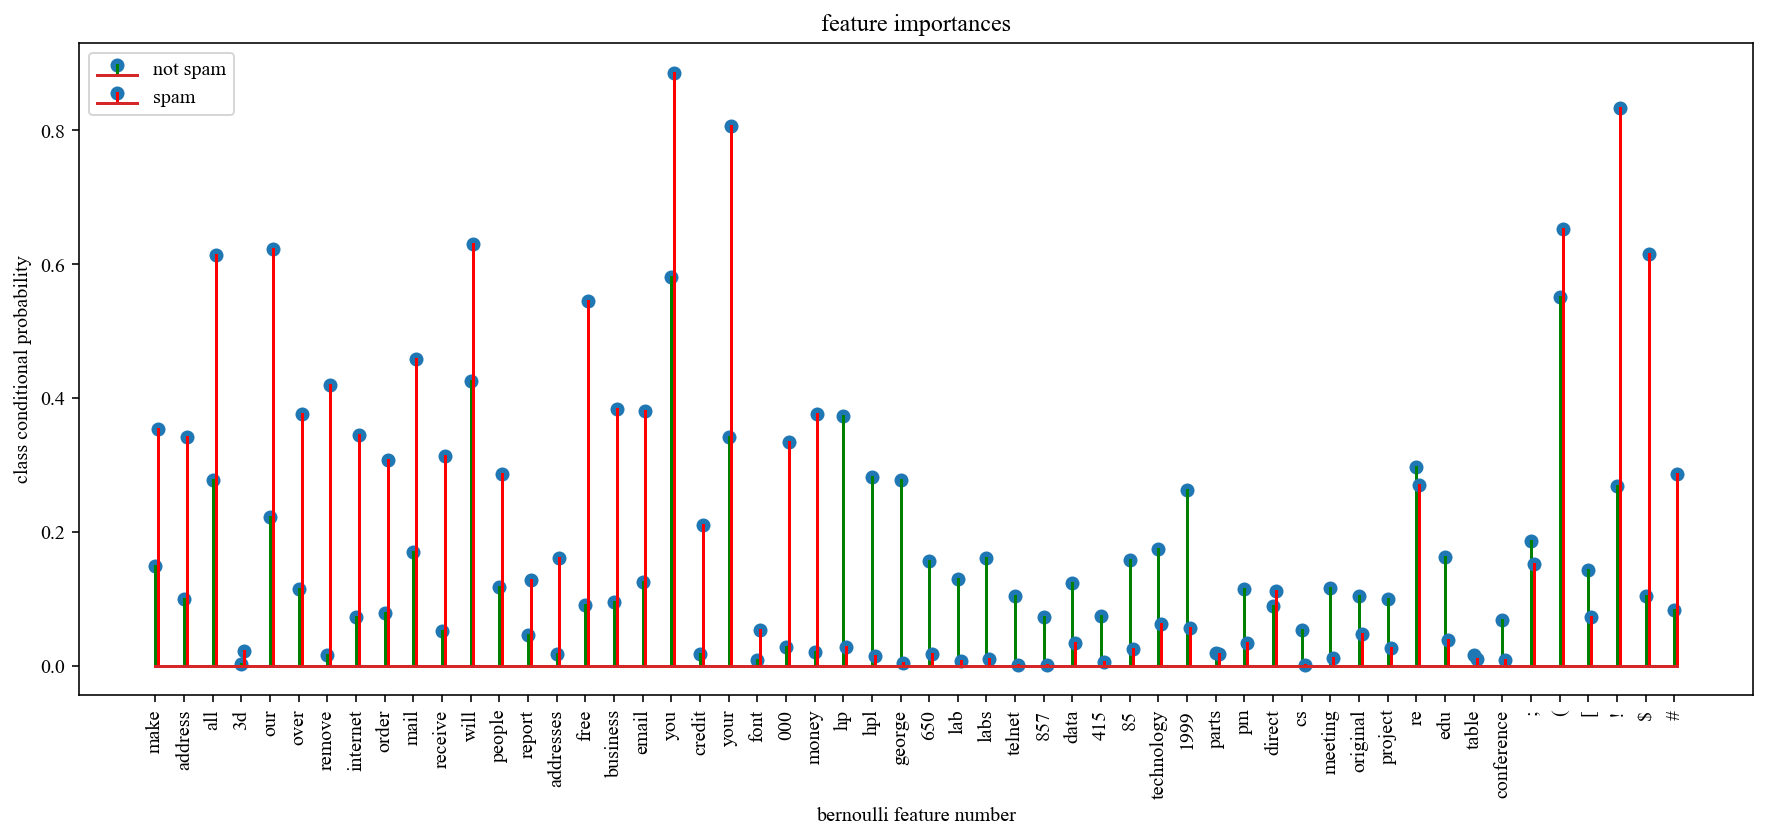

In [46]:
# parse documentation to map each Bernoulli feature to its corresponding token
with open(os.path.join(data_path, 'spambase.names'), 'rt') as f:
    words = f.readlines()
    
lines = words[35:]

features = list()
for line in lines:
    features.append(line.split())
    
features = pd.DataFrame(features, columns = ['index', 'token', 'type'])
features = features.drop('type', axis = 'columns')

def clean(x):
    x = x.replace('word_freq_', '').replace(':', '').replace('char_freq_', '')
    return x

features['token'] = features['token'].apply(clean)

# create stem plot
plt.figure(figsize = (15,6))
params_class_0 = np.exp(mnb.log_class_conditional_bernoulli.iloc[:,0])
params_class_1 = np.exp(mnb.log_class_conditional_bernoulli.iloc[:,1])
ax = plt.gca()
ax.stem(np.arange(len(params_class_0)),
         params_class_0, 'green', label = 'not spam', mfc = 'black')
ax.stem(np.arange(len(params_class_1))+0.1,
         params_class_1, 'red', label = 'spam')
ax.set(xticks = range(0, len(params_class_0 + 1)),
       xlabel = 'bernoulli feature number',
       ylabel = 'class conditional probability',
       title = 'feature importances')
ax.set_xticklabels(features['token'][:-3], rotation = 90)
ax.legend()